In [2]:
from fretbursts import *
sns = init_notebook()

In [3]:
full_fname='../data/n25c.h5'
d = loader.photon_hdf5(full_fname)

In [4]:
d.time_max

2400.0478221713915

In [5]:
d.det_t

[array([1, 0, 0, ..., 0, 0, 1], dtype=uint8)]

In [6]:
print("Detector    Counts")
print("--------   --------")
for det, count in zip(*np.unique(d.det_t, return_counts=True)):
    print("%8d   %8d" % (det, count))

Detector    Counts
--------   --------
       0   11462403
       1    8911506


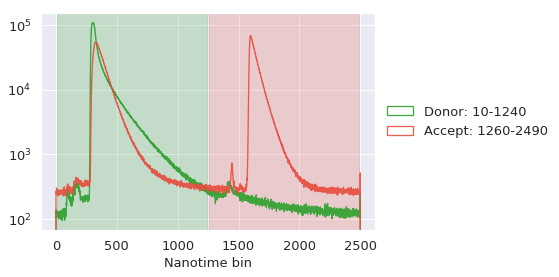

In [7]:
bpl.plot_alternation_hist(d)

In [8]:
loader.alex_apply_period(d)

# Total photons (after ALEX selection):    20,354,229
#  D  photons in D+A excitation periods:    8,903,524
#  A  photons in D+A excitation periods:   11,450,705
# D+A photons in  D  excitation period:    14,979,672
# D+A photons in  A  excitation period:     5,374,557



In [9]:
d.calc_bg(fun=bg.exp_fit, time_s=30, tail_min_us='auto', F_bg=1.7)

 - Calculating BG rates ... [DONE]


In [10]:
mask_dd = d.get_ph_mask(ph_sel=Ph_sel(Dex='Dem')) 
print(mask_dd[1:10])

[False False False False False False  True  True  True]


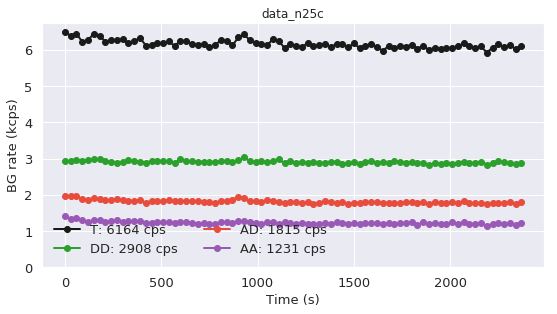

In [11]:
dplot(d, timetrace_bg)

(-50, 50)

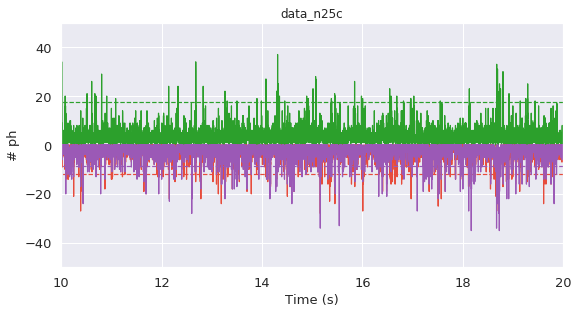

In [12]:
dplot(d, timetrace)
xlim(10, 20)
ylim(-50, 50)


In [13]:
d.burst_search()

 - Performing burst search (verbose=False) ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A]


In [14]:
ph = d.get_ph_times()
ns=d.nanotimes

len(ph),len(ns[0])

(20354229, 20354229)

In [15]:
import numpy as np
print(np.mean(d.TT),len(d.TT[0]))

0.0002704380292014345 80


In [16]:
ds = d.select_bursts(select_bursts.naa, th1=3, computefret=False)
ds = ds.select_bursts(select_bursts.size, th1=25)
ds = ds.fuse_bursts(ms=0)

 - - - - - CHANNEL  1 - - - - 
 --> END Fused 45 bursts (1.1%, 3 iter)

 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A and FRET]


/home/parallels/.local/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


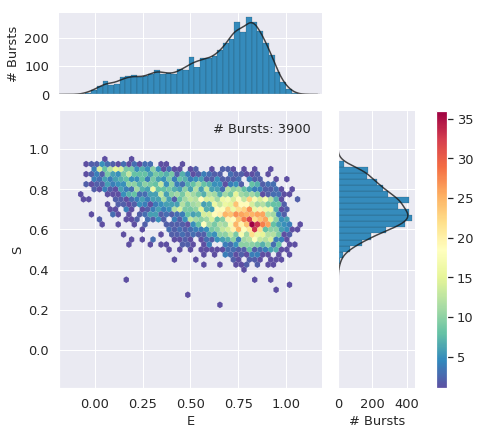

In [17]:
alex_jointplot(ds)

/home/parallels/.local/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


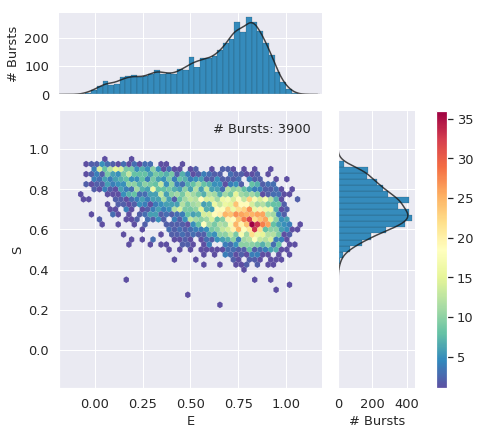

In [18]:
alex_jointplot(ds)

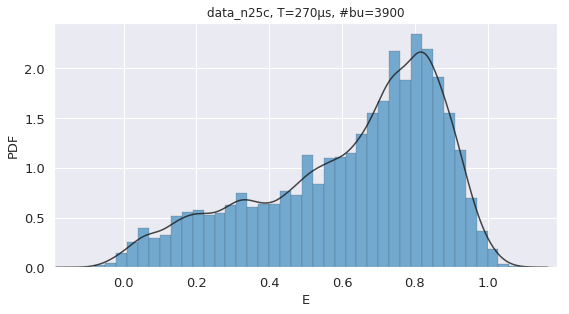

In [19]:
dplot(ds, hist_fret, show_kde=True)

In [20]:
nanotimes = d.nanotimes[0]
nanotimes_d = nanotimes[d.get_D_em()]
nanotimes_a = nanotimes[d.get_A_em()]

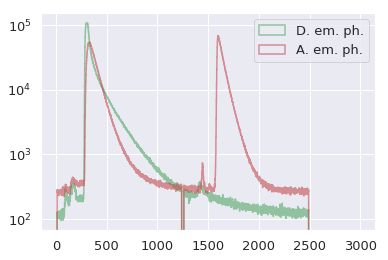

In [21]:
hist_params = dict(bins=range(3000), histtype='step', alpha=0.6, lw=1.5)
#hist(nanotimes, color='k', label='Total ph.', **hist_params)
hist(nanotimes_d, color='g', label='D. em. ph.', **hist_params)
hist(nanotimes_a, color='r', label='A. em. ph.', **hist_params)
plt.legend()
plt.yscale('log')

/home/parallels/.local/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


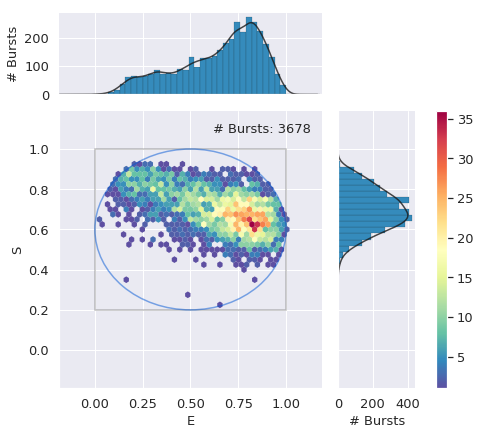

In [22]:
roi = dict(E1=0, E2=1, S1=0.2, S2=1, rect=False)
d_fret_mix = ds.select_bursts(select_bursts.ES, **roi)
g = alex_jointplot(d_fret_mix)
bpl.plot_ES_selection(g.ax_joint, **roi);

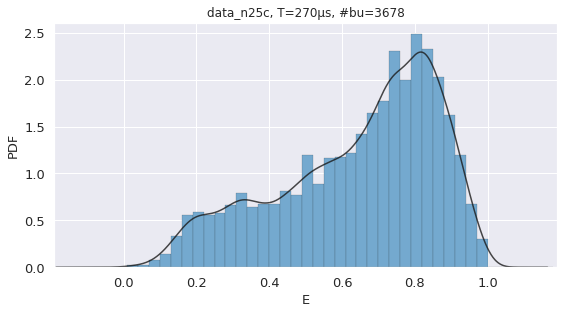

In [23]:
dplot(d_fret_mix, hist_fret, show_kde=True)

In [31]:
from fretbursts.phtools.burstsearch import Burst, Bursts
times = d.ph_times_m[0]  # timestamps array
bursts = d_fret_mix.mburst[0]
print('\nNumber of bursts:', bursts.num_bursts)
mask_dd = d.get_ph_mask(ph_sel=Ph_sel(Dex='Dem')) 
t=times[20:40]
m=mask_dd[20:40]
print(t[m])


Number of bursts: 3678
[ 53165  67307  68013  69205  73086  84747  95802 110187 113443 113766]


In [26]:
times.shape


(20354229,)

In [28]:
mask_dd[100:150].shape

(50,)

In [ ]:
time_bin = 0.5e-3  # 0.5 ms
time_bin_clk = time_bin / ds.clk_p

sub_bursts_list = []
for burst in bursts:
    # Compute binning of current bursts
    bins = np.arange(burst.start, burst.stop + time_bin_clk, time_bin_clk)
    counts, _ = np.histogram(times[burst.istart:burst.istop+1], bins)
    
    # From `counts` in each bin, find start-stop times and indexes (sub-burst).
    # Note that start and stop are the min and max timestamps in the bin,
    # therefore they are not on the bin edges. Also the burst width is not
    # exactly equal to the bin width.
    sub_bursts_l = []
    sub_start = burst.start
    sub_istart = burst.istart
    for count in counts:
        # Let's skip bins with 0 photons
        if count == 0:
            continue
            
        sub_istop = sub_istart + count - 1
        sub_bursts_l.append(Burst(istart=sub_istart, istop=sub_istop,
                                  start=sub_start, stop=times[sub_istop]))
        
        sub_istart += count 
        sub_start = times[sub_istart]
    
    sub_bursts = Bursts.from_list(sub_bursts_l)
    assert sub_bursts.num_bursts > 0
    assert sub_bursts.width.max() < time_bin_clk
    sub_bursts_list.append(sub_bursts)

In [ ]:
len(sub_bursts_list)

In [ ]:
d_fret_mix.num_bursts

In [ ]:
iburst = 100
print('Sub-bursts from burst %d:' % iburst)
sub_bursts_list[iburst]

In [ ]:
(869175247-869183230)*ds.clk_p,ds.clk_p

In [ ]:
439824-439803

In [ ]:
nanotimes[2:9]

In [ ]:
lbursts = sub_bursts_list[0]
lbursts

In [ ]:
mask_dd = d.get_ph_mask(ph_sel=Ph_sel(Dex='Dem'))   # donor excitation, donor emission
mask_ad = d.get_ph_mask(ph_sel=Ph_sel(Dex='Aem'))   # donor excitation, acceptor emission
mask_aa = d.get_ph_mask(ph_sel=Ph_sel(Aex='Aem'))   # acceptor excitation, acceptor emission
from fretbursts.phtools.burstsearch import count_ph_in_bursts
gamma=0.34
beta=1.42
DexDirAem=0.08
Dch2Ach=0.07 

counts_dd = count_ph_in_bursts(bursts, mask_dd)
counts_ad = count_ph_in_bursts(bursts, mask_ad)
counts_aa = count_ph_in_bursts(bursts, mask_aa)
e=((counts_ad *(1-DexDirAem)-Dch2Ach*counts_dd)/ ((gamma-\
                            Dch2Ach)*counts_dd + (1-DexDirAem)*counts_ad)).tolist()    
# bursts.num_burst
len(e)

In [ ]:
import fretbursts
l=fretbursts.burstlib_ext.calc_mean_lifetime(d_fret_mix,250,1200,ph_sel=Ph_sel(Dex='DAem'))

In [ ]:
dplot(ds, hist_fret, show_kde=True)

In [ ]:
lt=((l[0]*2.5e-2)-2.1)/4.1
gamma=0.34        
beta=1.42
DexDirAem=0.08
Dch2Ach=0.07 
fE=fretbursts.fretmath.correct_E_gamma_leak_dir(ds.E[0],gamma, leakage=Dch2Ach, dir_ex_t=DexDirAem)

In [ ]:
plt.hist(e,50)

In [ ]:
plt.hist(fE,50)

In [ ]:

import scipy.io as sio
from array import array

Fsel=array("d")
for i in e:
    if i<0.999 and i >0.001:
        Fsel.append(i*100)
sio.savemat('fret.mat', {'fret':Fsel})

In [ ]:
times = d.ph_times_m[0]

In [ ]:
times[2994]

In [ ]:
bursts.start

In [ ]:
bursts.istart